# **Face Recognition**

### **Contributers:** 
### Shams Hossam Zayan &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 6854
### Youmna Elmezayen &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 6887 
### Maryam Abdou Abdelfattah &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 7071

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/faces.zip", 'r')
zip_ref.extractall("/faces")
zip_ref = zipfile.ZipFile("/non-faces.zip", 'r')
zip_ref.extractall("/non-faces")
zip_ref.close()

## Our functions:
1- PCA function. \
2- LDA function. \
3- KNN function. \
4- setData for faces. \
5- setData for non-faces and join with faces. \
6- PCA_diffAlphas for plotting PCA as alpha changes. \
7- PCA_diffKs for plotting PCA as K changes. \
8- LDA_acc for displaying LDA accuracy. \
9- LDA_diffKs for plotting LDA as K changes. \
10- PCA for dealing with data of faces and nonfaces. \
11- LDA for dealing with data of faces and nonfaces. \
12- diff_NonFacesPCA for applying PCA for different amounts of nonfaces data. \
13- diff_NonFacesLDA for applying LDA for different amounts of nonfaces data. 


In [ ]:
from PIL import Image
from numpy import asarray
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import confusion_matrix

def pca(test, train):
    mean_train = np.mean(train, axis=0)
    train_centeralized = np.subtract(train, mean_train)
    mean_test = np.mean(test, axis=0)
    test_centeralized = np.subtract(test, mean_test)

    cov_matrix = np.cov(train_centeralized.T, bias=True) # bias true for population covarience (/n)
    eigenvalues,eigenvectors=np.linalg.eigh(cov_matrix)
    idx = eigenvalues.argsort()[::-1]    # to sort eigen vectors from largest to smallest
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    eigenvalues1 = np.diag(eigenvalues)
    return eigenvectors,eigenvalues,train_centeralized,test_centeralized

def pca2(eigenvectors,eigenvalues,alpha,train_centeralized,test_centeralized):

    total_eigen = np.sum(eigenvalues)
    eigen = 0
    i=0
    while (eigen / total_eigen) < alpha :
        eigen=eigen+eigenvalues[i]
        i+=1
    eigenvectors_1 = eigenvectors[:,:i-1]
    explained_varience = eigen/total_eigen
    D_train= np.dot(train_centeralized, eigenvectors_1)
    D_test= np.dot(test_centeralized, eigenvectors_1)
    return D_test,D_train
   

def lda(test, train, eigno, train_len, split):
    #get mean of each of 40 classes
    mean = np.array([])  #[40, 10304]
    for i in range(0,train_len,split):
        m = np.mean(train[0+i:split+i, :], axis=0)  #[1, 10304]
        if i == 0:
            mean = np.hstack((mean,m))
        else:
            mean = np.vstack((mean,m))

    total_mean = np.mean(train, axis=0)


    #get B
    Sb = np.array([])
    for i in range(eigno + 1):
        mean_diff = mean[i, :] - total_mean
        mul = np.outer(mean_diff, np.transpose(mean_diff))
        b = split*mul
        if i==0:
            Sb = b
        else:
            Sb += b

    #get S
    j = 0
    S = np.array([])  #[10304, 10304]
    for i in range(0,train_len,split):
        Z_train = train[0+i:split+i, :] - mean[j, :]
        s = np.dot(np.transpose(Z_train), Z_train)
        if i == 0:
            S = s
        else:
            S += s
        j+=1

    S_inv = np.linalg.inv(S)
    S_inv_b = np.dot(S_inv, Sb)
    value,U = np.linalg.eigh(S_inv_b)
    idx = np.argsort(-value)
    value = value[idx]
    U = U[:,idx]
    proj_U = U[:, 0:eigno]

    train_centeralized = train - total_mean
    mean_test = np.mean(test, axis=0)
    test_centeralized = test - mean_test

    proj_test = np.dot(test_centeralized, proj_U)
    proj_train = np.dot(train_centeralized, proj_U)

    return proj_test , proj_train


def knn(k, test, train, label_train,label_test):
    accuracy = []

    for i in k:
        knn = KNeighborsClassifier(n_neighbors=i, weights="distance")
        knn.fit(train, label_train)

        predicted = knn.predict(test)
        accuracy.append(accuracy_score(label_test, predicted))

    return accuracy , predicted


def setData_faces(D, split):
    if split == 0.5:   
        k=0
        train = D[::2]
        test = D[1::2]
        label_train = np.zeros(200)
        for i in range(40):
            for j in range(5):
                label_train[k]=i+1
                k=k+1
        k=0
        label_test = np.zeros(200)
        for i in range(40):
            for j in range(5):
                label_test[k]=i+1
                k=k+1
    
    else:
        train = np.empty((0,10304))
        test = np.empty((0,10304))
        for i in range(0, 400, 10):
            train = np.append(train, D[0+i:7+i:1], axis=0)
            test = np.append(test, D[7+i:10+i:1], axis=0)

        k=0
        label_train = np.zeros(280)
        for i in range(40):
            for j in range(7):
                label_train[k]=i+1
                k=k+1
        k=0
        label_test = np.zeros(120)
        for i in range(40):
            for j in range(3):
                label_test[k]=i+1
                k=k+1
                


    return train, test, label_train,label_test



def setData_nonfaces(non_faces, D, split):
    N = np.array([]) 
    for i in range (1, non_faces + 1):
        image = Image.open(fr'/non-faces/sunflower/1 ({i}).jpg')
        img_gray = image.convert('L')
        image_crop = img_gray.resize((92, 112))
        numpydata = asarray(image_crop).reshape(-1) # turn into 1D array (vector)
        if i ==1 :
            N = np.hstack((N,numpydata))
        else:
            N = np.vstack((N,numpydata))


    if split == 0.5:
        train_D = D[::2]
        test_D = D[1::2]
        train_N = N[::2]
        test_N = N[1::2]
        train = np.concatenate((train_D, train_N), axis=0)
        test = np.concatenate((test_D, test_N), axis=0)
    
    else:
        train_D = np.empty((0,10304))
        test_D = np.empty((0,10304))
        for i in range(0, 400, 10):
            train_D = np.append(train_D, D[0+i:7+i:1], axis=0)
            test_D = np.append(test_D, D[7+i:10+i:1], axis=0)

        train_N = np.empty((0,10304))
        test_N = np.empty((0,10304))
        for i in range(0, 400, 10):
            train_N = np.append(train_N, N[0+i:7+i:1], axis=0)
            test_N = np.append(test_N, N[7+i:10+i:1], axis=0)

        train = np.concatenate((train_D, train_N), axis=0)
        test = np.concatenate((test_D, test_N), axis=0)

    k=0
    label_train_nonfaces = np.zeros(len(train))  
    for j in range(len(train_D)):
        label_train_nonfaces[k] = 1
        k+=1

    for j in range(len(train_N)):
        label_train_nonfaces[k] = 2
        k+=1

    k=0
    label_test_nonfaces = np.zeros(len(test))  
    for j in range(len(test_D)):
        label_test_nonfaces[k] = 1
        k+=1

    for j in range(len(test_N)):
        label_test_nonfaces[k] = 2
        k+=1
    
    return train, test, label_train_nonfaces,label_test_nonfaces

def PCA_diffAlpha(alpha,train,test,label_train,label_test):
    accuracy=[]
    eigenvectors,eigenvalues,train_centeralized,test_centeralized= pca(test, train)
    for i in alpha:
        proj_test,proj_train= pca2(eigenvectors,eigenvalues,i,train_centeralized,test_centeralized)
        acc,pre=knn([1], proj_test, proj_train, label_train, label_test)
        accuracy.append(acc)
    plt.plot(alpha, accuracy)
    plt.title('PCA with different alphas at k = 1')
    plt.xlabel('alpha')
    plt.ylabel('accuracy')
    plt.show()

def PCA_diffKs(train,test,label_train,label_test):
    k=[1, 3, 5, 7]
    eigenvectors,eigenvalues,train_centeralized,test_centeralized= pca(test, train)
    proj_test,proj_train= pca2(eigenvectors,eigenvalues,0.8,train_centeralized,test_centeralized)
    acc,pre = knn(k,proj_test, proj_train,label_train,label_test)
    plt.plot(k, acc)
    plt.title('PCA with different K at alpha = 0.8')
    plt.xlabel('K')
    plt.ylabel('accuracy')
    plt.show()

def LDA_acc(test, train, label_train,label_test,eigno, train_length, split):
    proj_test,proj_train= lda(test, train,eigno, train_length, split)
    acc,pre=knn([1], proj_test, proj_train,label_train,label_test)
    print(acc)

def LDA_diffKs(test, train, label_train,label_test,eigno, train_length, split):
    k=[1, 3, 5, 7]
    proj_test,proj_train= lda(test, train, eigno, train_length, split)
    acc,pre = knn(k, proj_test, proj_train, label_train, label_test)
    plt.plot(k, acc)
    plt.title('LDA with different K')
    plt.xlabel('K')
    plt.ylabel('accuracy')
    plt.show()

def NonFaces_Pca( train_nonfaces, test_nonfaces, label_train_nonfaces,label_test_nonfaces):
    eigenvectors,eigenvalues,train_centeralized,test_centeralized= pca(test_nonfaces, train_nonfaces)
    proj_test,proj_train= pca2(eigenvectors,eigenvalues,0.8,train_centeralized,test_centeralized)
    acc,pre=knn([1], proj_test, proj_train, label_train_nonfaces,label_test_nonfaces)
    cm = confusion_matrix(label_test_nonfaces, pre)
    print('confusion matrix: ',cm)
    print('predicted: ',pre[len(pre)-9:len(pre)-6])
    for i in range(len(test_nonfaces) - 9,len(test_nonfaces) - 6):
        figure = test_nonfaces[i, :].reshape(112,92)
        plt.imshow(figure, cmap='gray')
        plt.figure()


def NonFaces_lda( train_nonfaces, test_nonfaces, label_train_nonfaces,label_test_nonfaces,eigno, train_length, split):
    proj_test,proj_train= lda(test_nonfaces, train_nonfaces,eigno, train_length, split)
    acc,pre=knn([1], proj_test, proj_train, label_train_nonfaces,label_test_nonfaces)
    cm = confusion_matrix(label_test_nonfaces, pre)
    print('confusion matrix: ',cm)
    print('predicted: ',pre[0:3:1])
    for i in range(3):
        figure = test_nonfaces[i, :].reshape(112,92)
        plt.imshow(figure, cmap='gray')
        plt.figure()

def diff_nonFacesPCA(D, split):
    nonFaces=[200, 300, 400, 500, 600]
    accuracy=[]
    for i in nonFaces:
        train_nonfaces, test_nonfaces, label_train_nonfaces,label_test_nonfaces = setData_nonfaces(i, D, split)
        eigenvectors,eigenvalues,train_centeralized,test_centeralized= pca(test_nonfaces, train_nonfaces)
        proj_test,proj_train= pca2(eigenvectors,eigenvalues,0.8,train_centeralized,test_centeralized)
        acc,pre=knn([1], proj_test, proj_train, label_train_nonfaces,label_test_nonfaces)
        accuracy.append(acc)
    plt.plot(nonFaces, accuracy)
    plt.title('different nonfaces with acc')
    plt.xlabel('nonFaces')
    plt.ylabel('accuracy')
    plt.show()

def diff_nonFacesLDA(D, split,eigno, train_length, split_data):
    nonFaces=[200, 300, 400, 500, 600]
    accuracy=[]
    for i in nonFaces:
        train_nonfaces, test_nonfaces, label_train_nonfaces,label_test_nonfaces = setData_nonfaces(i, D, split)
        proj_test,proj_train= lda(test_nonfaces, train_nonfaces, eigno, train_length, split_data)
        acc,pre=knn([1], proj_test, proj_train, label_train_nonfaces,label_test_nonfaces)
        accuracy.append(acc)
    plt.plot(nonFaces, accuracy)
    plt.title('different nonfaces with acc')
    plt.xlabel('nonFaces')
    plt.ylabel('accuracy')
    plt.show()




D = np.array([])
for i in range (1,41):
    for j in range (1,11):
        image = Image.open(fr'/faces/s{i}/{j}.pgm')
        numpydata = asarray(image).reshape(-1) # turn into 1D array (vector)
        if i ==1 and j ==1 :
            D = np.hstack((D,numpydata))
        else:
            D = np.vstack((D,numpydata))

## Setting data

In [ ]:
train_faces, test_faces, label_train,label_test =  setData_faces(D, 0.5)
train_faces2, test_faces2, label_train2, label_test2 =  setData_faces(D, 0.7)
alpha = [0.8,0.85,0.9,0.95]

### Plot PCA with different alphas (for 0.5 split)

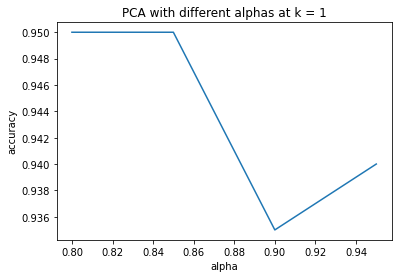

In [ ]:
PCA_diffAlpha(alpha,train_faces,test_faces,label_train,label_test)

### Plot PCA with different alphas (for 0.7 split)

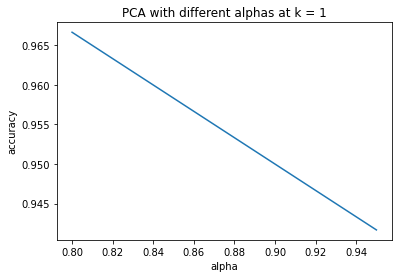

In [ ]:
PCA_diffAlpha(alpha,train_faces2,test_faces2,label_train2,label_test2)

### Plot PCA with different Ks (for 0.5 split)

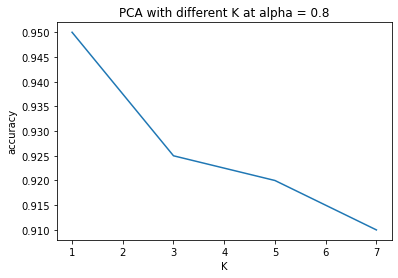

In [ ]:
PCA_diffKs(train_faces,test_faces,label_train,label_test)

### Plot PCA with different Ks (for 0.7 split)

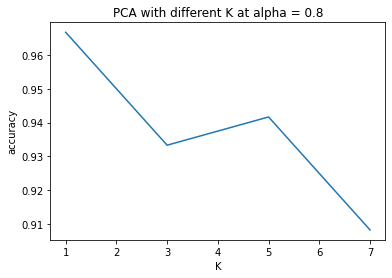

In [ ]:
PCA_diffKs(train_faces2,test_faces2,label_train2,label_test2)

### Get LDA accuracy (for 0.5 split)

In [ ]:
LDA_acc(test_faces, train_faces, label_train,label_test,39, 200, 5)

[0.95]


### Get LDA accuracy (for 0.7 split)

In [ ]:
LDA_acc(test_faces2, train_faces2, label_train2,label_test2,39, 280, 7)

[0.9333333333333333]


### Plot LDA with different Ks (for 0.5 split)

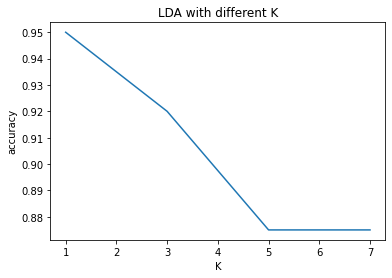

In [ ]:
LDA_diffKs(test_faces, train_faces, label_train,label_test,39, 200, 5)

### Plot LDA with different Ks (for 0.7 split)

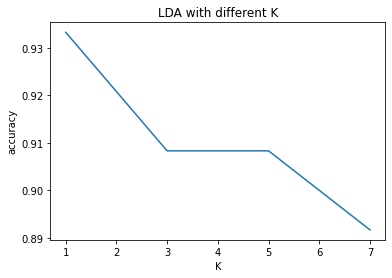

In [ ]:
LDA_diffKs(test_faces2, train_faces2, label_train2,label_test2,39, 280, 7)

### Set nonfaces data and join with faces data to test together

In [ ]:
train_nonfaces, test_nonfaces, label_train_non,label_test_non = setData_nonfaces(400, D, 0.5)
train_nonfaces2, test_nonfaces2, label_train_non2,label_test_non2 = setData_nonfaces(400, D, 0.7)

### Plot PCA with different alphas for nonfaces data (for 0.5 split)

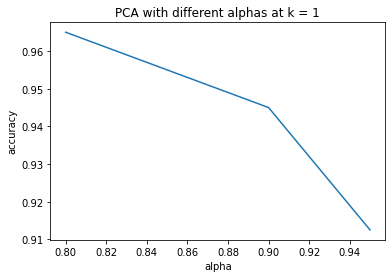

In [ ]:
PCA_diffAlpha(alpha,train_nonfaces,test_nonfaces,label_train_non,label_test_non)

### Plot PCA with different alphas for nonfaces data (for 0.7 split)

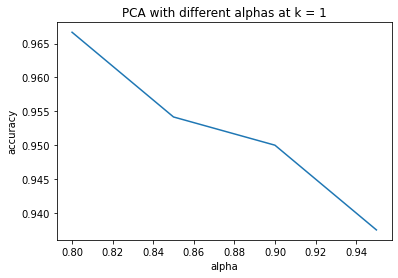

In [ ]:
PCA_diffAlpha(alpha,train_nonfaces2,test_nonfaces2,label_train_non2,label_test_non2)

### Plot PCA with different Ks for nonfaces data (for 0.5 split)

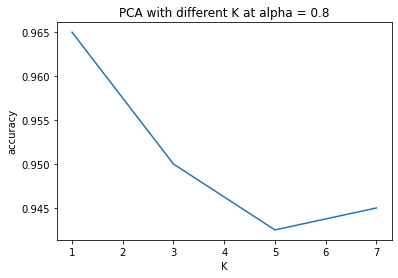

In [ ]:
PCA_diffKs(train_nonfaces,test_nonfaces,label_train_non,label_test_non)

### Plot PCA with different Ks for nonfaces data (for 0.7 split)

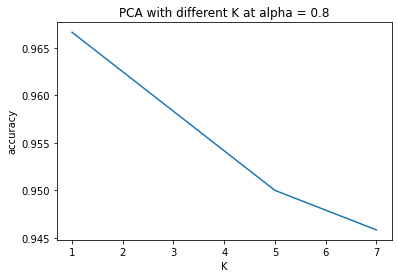

In [ ]:
PCA_diffKs(train_nonfaces2,test_nonfaces2,label_train_non2,label_test_non2)

### Get LDA accuracy for nonfaces data (for 0.5 split)

In [ ]:
LDA_acc(test_nonfaces, train_nonfaces, label_train_non,label_test_non,1, 200, 5)

[0.5625]


### Get LDA accuracy for nonfaces data (for 0.7 split)

In [ ]:
LDA_acc(test_nonfaces2, train_nonfaces2, label_train_non2,label_test_non2,1, 280, 7)

[0.7458333333333333]


### Plot LDA with different Ks for nonfaces data (for 0.5 split)

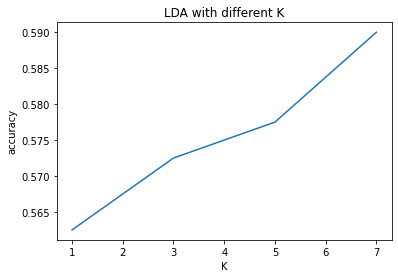

In [ ]:
LDA_diffKs(test_nonfaces, train_nonfaces, label_train_non,label_test_non,1, 200, 5)

### Plot LDA with different Ks for nonfaces data (for 0.7 split)

In [ ]:
LDA_diffKs(test_nonfaces2, train_nonfaces2, label_train_non2,label_test_non2,1, 280, 7)

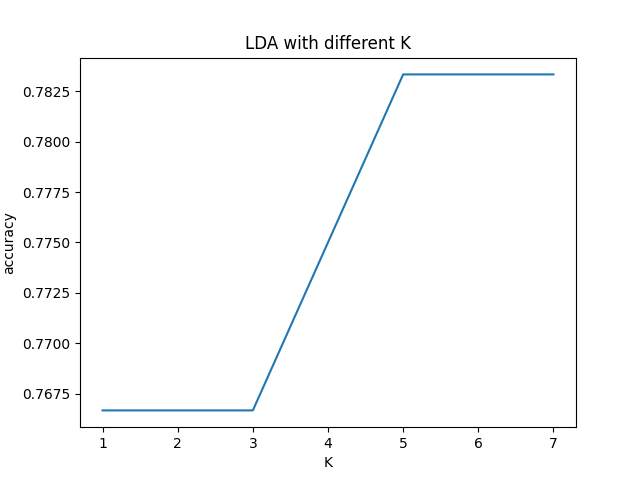

### Get confusion matrix of PCA for nonfaces data (for 0.5 split)

confusion matrix:  [[200   0]
 [ 14 186]]
predicted:  [1. 2. 2.]


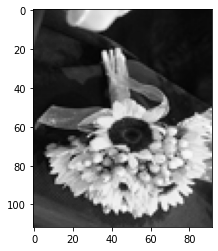

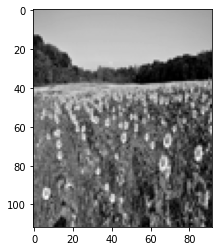

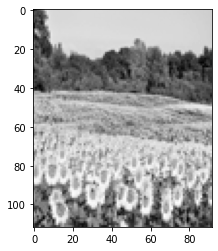

<Figure size 432x288 with 0 Axes>

In [ ]:
NonFaces_Pca( train_nonfaces, test_nonfaces, label_train_non,label_test_non)

### Get confusion matrix of PCA for nonfaces data (for 0.7 split)

confusion matrix:  [[120   0]
 [  8 112]]
predicted:  [2. 2. 2.]


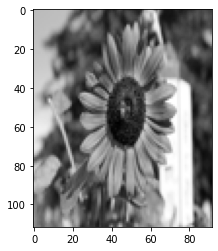

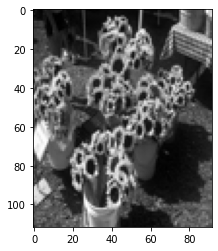

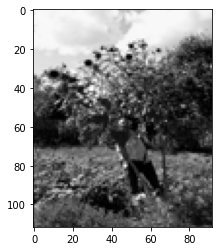

<Figure size 432x288 with 0 Axes>

In [ ]:
NonFaces_Pca( train_nonfaces2, test_nonfaces2, label_train_non2,label_test_non2)

### Get confusion matrix of LDA for nonfaces data (for 0.5 split)

confusion matrix:  [[121  79]
 [ 96 104]]
predicted:  [1. 2. 1.]


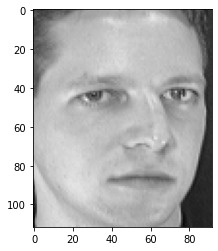

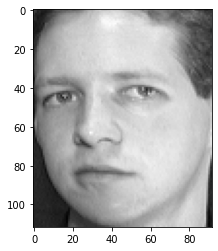

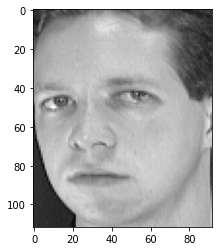

<Figure size 432x288 with 0 Axes>

In [ ]:
NonFaces_lda( train_nonfaces, test_nonfaces, label_train_non,label_test_non,1, 200, 5)

### Get confusion matrix of LDA for nonfaces data (for 0.7 split)

confusion matrix:  [[85 35]
 [26 94]]
predicted:  [1. 2. 1.]


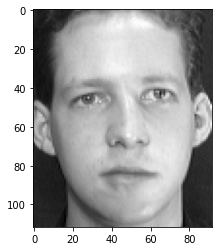

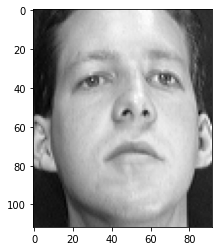

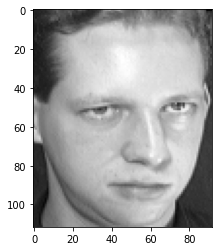

<Figure size 432x288 with 0 Axes>

In [ ]:
NonFaces_lda( train_nonfaces2, test_nonfaces2, label_train_non2,label_test_non2,1, 280, 7)

### Plot PCA for different amounts of nonfaces data (for 0.5 split)

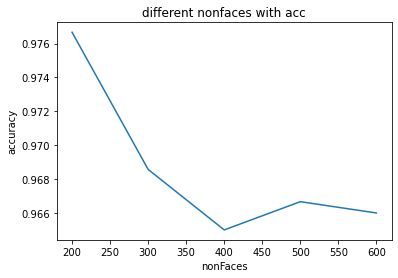

In [ ]:
diff_nonFacesPCA(D, 0.5)

### Plot PCA for different amounts of nonfaces data (for 0.7 split)

In [ ]:
diff_nonFacesPCA(D, 0.7)

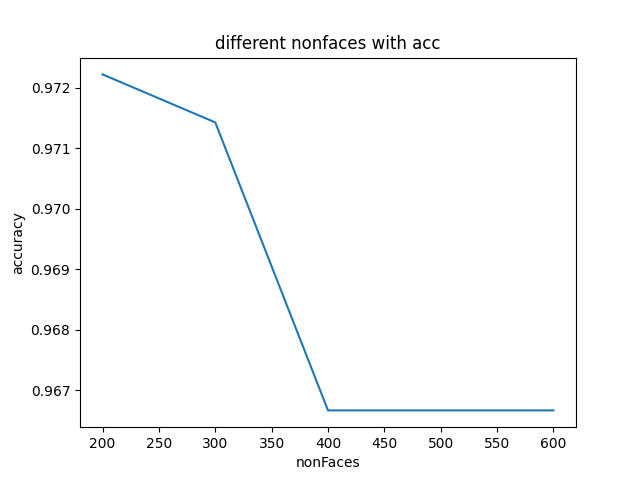

### Plot LDA for different amounts of nonfaces data (for 0.5 split)

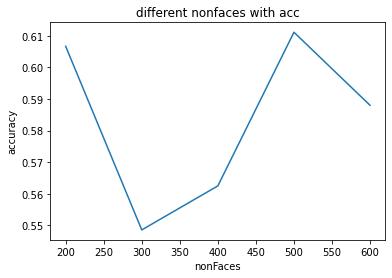

In [ ]:
diff_nonFacesLDA(D, 0.5,1, 200, 5)

### Plot LDA for different amounts of nonfaces data (for 0.7 split)

In [ ]:
diff_nonFacesLDA(D, 0.7,1, 280, 7)

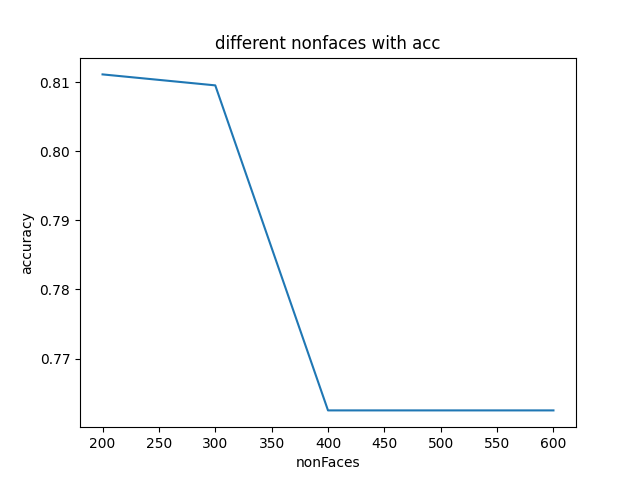

## Other  variations  of  PCA  and  LDA  

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def pca_algo(train_faces, test_faces, label_train,label_test):
  kpca = KernelPCA(kernel="linear", n_components=40, gamma=15)
  X_train = kpca.fit_transform(train_faces)
  X_test = kpca.transform(test_faces)
  classifier = LogisticRegression(random_state = 0, max_iter=1000)
  classifier.fit(X_train, label_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(label_test, y_pred)
  print(accuracy)

def lda_algo(train_faces, test_faces, label_train,label_test):
  lda = LDA()
  X_train=lda.fit_transform(train_faces, label_train)
  X_test = lda.transform(test_faces)
  classifier = LogisticRegression(random_state = 0, max_iter=1000)
  classifier.fit(X_train, label_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(label_test, y_pred)
  print(accuracy)



### Accuracy of PCA using sklearn

In [ ]:
pca_algo(train_faces, test_faces, label_train,label_test)

0.97


### Accuracy of LDA using sklearn

In [ ]:
lda_algo(train_faces, test_faces, label_train,label_test)

0.96
